# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Facial Expression Recognition</span></span></center></h1> 

In [119]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.utils.all_utils import to_categorical
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras import models

import warnings
warnings.filterwarnings("ignore")

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Load the Dataset</span></span></center></h1> 

In [3]:
data = pd.read_csv('icml_face_data.csv')

In [4]:
data

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Preprocessing Dataset</span></span></center></h1>

In [5]:
def prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels and pixel data
        output: image and label array """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

Prepare the data-set

In [6]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [8]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])

Reshape and scale the images:

In [9]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

Encoding of the target value:

In [10]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)

In [11]:
train_images.shape

(28709, 48, 48, 1)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Analyzing the Dataset</span></span></center></h1>

In [12]:
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(20, 12))
    fig.subplots_adjust(hspace = .2, wspace=.1) # for giving the space
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

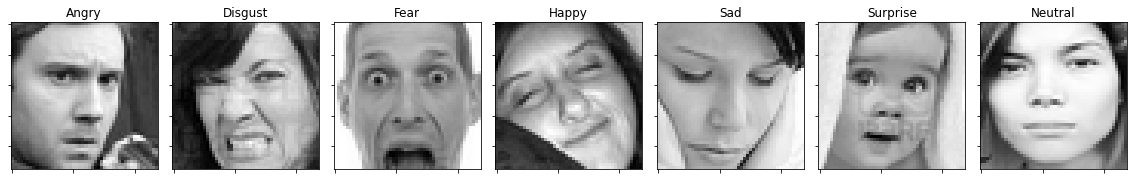

In [13]:
plot_all_emotions()

## Plot some examples

In [14]:
# make function to plot some example

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(15, 8))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
     

## Angry

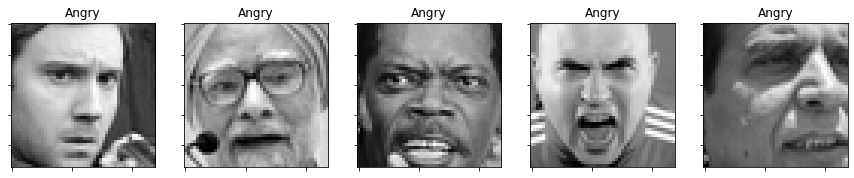

In [15]:
plot_examples(label=0)

## Disgust

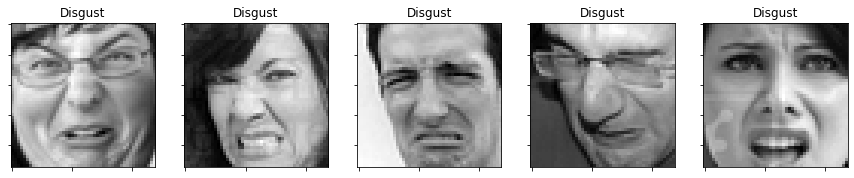

In [16]:
plot_examples(label=1)

## Fear

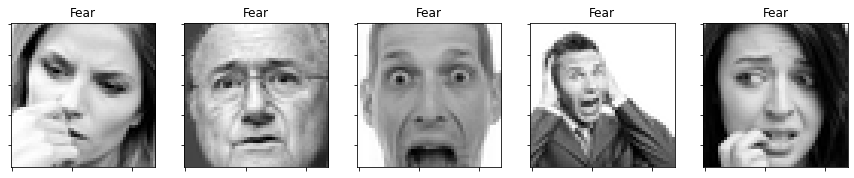

In [17]:
plot_examples(label=2)

## Happy

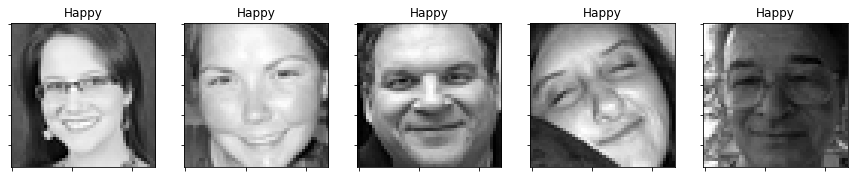

In [18]:
plot_examples(label=3)


## Sad

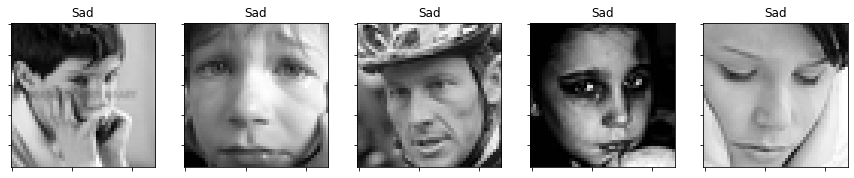

In [19]:
plot_examples(label=4)

## Surprise

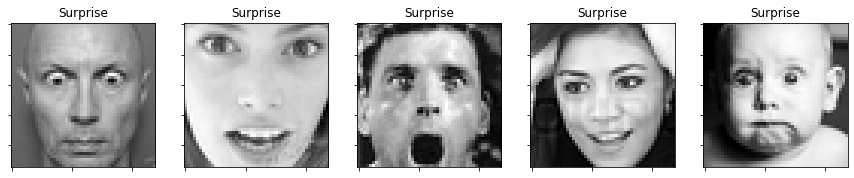

In [20]:
plot_examples(label=5)

## Neutral

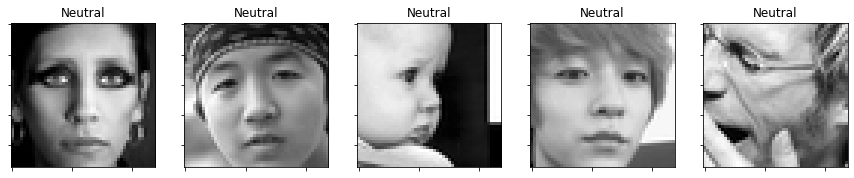

In [21]:
plot_examples(label=6)

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Distribution Of Labels</span></span></center></h1> 

In [22]:
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()


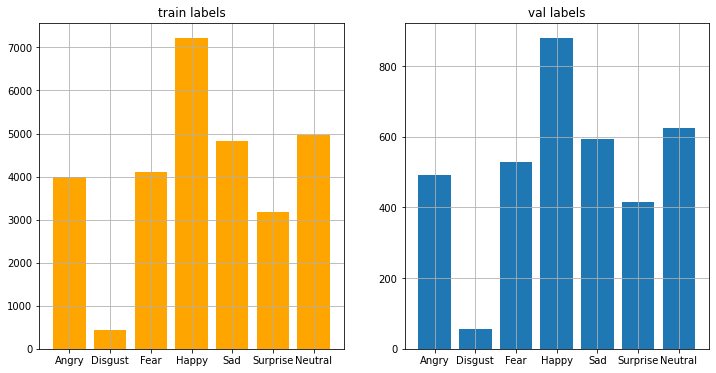

In [23]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Modelling</span></span></center></h1> 

In [39]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [45]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)        

In [54]:
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=5, batch_size=64)

Epoch 1/5
449/449 [==============================] - 6s 13ms/step - loss: 0.9924 - accuracy: 0.6278 - val_loss: 1.2033 - val_accuracy: 0.5400
Epoch 2/5
449/449 [==============================] - 5s 12ms/step - loss: 0.9682 - accuracy: 0.6319 - val_loss: 1.2205 - val_accuracy: 0.5489
Epoch 3/5
449/449 [==============================] - 5s 12ms/step - loss: 0.9416 - accuracy: 0.6478 - val_loss: 1.2460 - val_accuracy: 0.5453
Epoch 4/5
449/449 [==============================] - 6s 12ms/step - loss: 0.9189 - accuracy: 0.6535 - val_loss: 1.2105 - val_accuracy: 0.5522
Epoch 5/5
449/449 [==============================] - 5s 12ms/step - loss: 0.8965 - accuracy: 0.6652 - val_loss: 1.2375 - val_accuracy: 0.5500


# <h1 style='background:#CCCCCC; border:0; color:black'><center><span style="color: royalblue;"><span style="color: royalblue;">Prediction</span></span></center></h1> 

In [55]:
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [56]:
test_image_array.shape

(3589, 48, 48)

Reshaping the images

In [50]:
test_images = test_image_array.reshape((len(test_image_array), 48, 48, 1))
test_images = test_images.astype('float32')/255

In [51]:
test_images.shape

(3589, 48, 48, 1)

In [57]:
test_labels = to_categorical(test_image_label)

Load thee json model

In [58]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

113/113 [==============================] - 1s 6ms/step - loss: 1.2543 - accuracy: 0.5489


In [59]:
predict_images = model.predict(test_images)

Let's test the accuracy of our model

In [97]:
EMOTIONS_LIST = ["Angry", "Disgust",
                 "Fear", "Happy",
                 "Neutral", "Sad",
                 "Surprise"]
                 
# predict the image
print('Predicting expression :', EMOTIONS_LIST[np.argmax(predict_images[4])],
        '\nActual emotion :',  EMOTIONS_LIST[np.argmax(test_labels[4])])

print('Predicting expression :', EMOTIONS_LIST[np.argmax(predict_images[23])],
        '\nActual emotion :',  EMOTIONS_LIST[np.argmax(test_labels[23])])

print('Predicting expression :', EMOTIONS_LIST[np.argmax(predict_images[50])],
        '\nActual emotion :',  EMOTIONS_LIST[np.argmax(test_labels[50])])

print('Predicting expression :', EMOTIONS_LIST[np.argmax(predict_images[6])],
        '\nActual emotion :',  EMOTIONS_LIST[np.argmax(test_labels[6])])


Predicting expression : Happy 
Actual emotion : Happy
Predicting expression : Neutral 
Actual emotion : Neutral
Predicting expression : Angry 
Actual emotion : Angry
Predicting expression : Neutral 
Actual emotion : Fear


In [110]:
# Function to plot the image and compare the prediction results with the label
    
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    

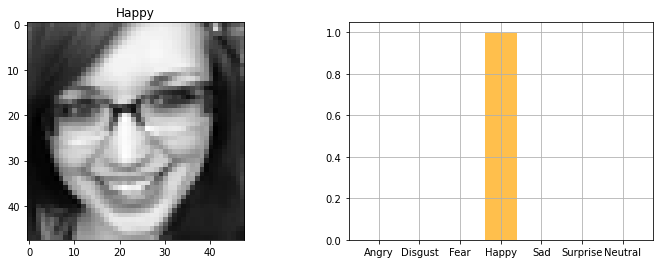

In [111]:
plot_image_and_emotion(test_image_array, test_image_label, predict_images, 4)

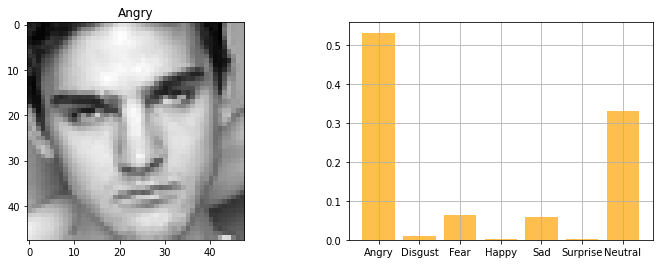

In [107]:
plot_image_and_emotion(test_image_array, test_image_label, predict_images, 50)

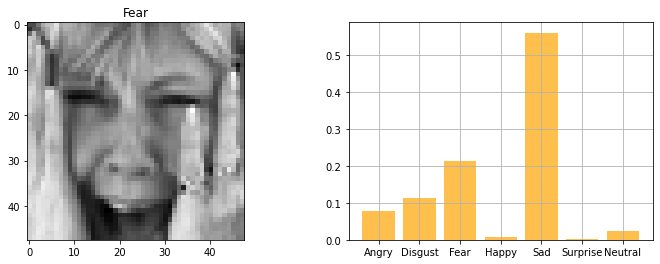

In [108]:
plot_image_and_emotion(test_image_array, test_image_label, predict_images, 6)

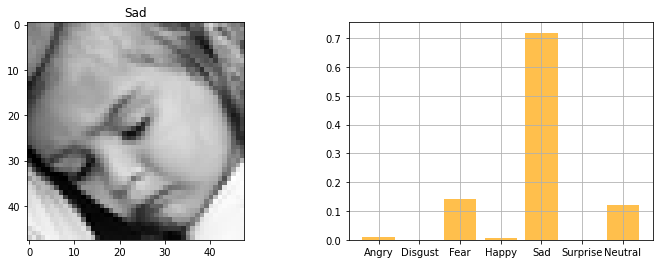

In [109]:
plot_image_and_emotion(test_image_array, test_image_label, predict_images, 23)

### It's performing quite well

Let's save the model so, we can use our model anytime without training it.

Save the model weights

In [114]:
model.save_weights('model_weights.h5')

In [115]:
model_json = model.to_json()
print(model_json)

with open('model.json', 'w') as json_file:
    json_file.write(model_json)

{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_4_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_4", "trainable": true, "batch_input_shape": [null, 48, 48, 1], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_4", "trainable": true, "dtype": "float32", "pool_size": [2, 2], "padding": "valid", "strides": [2,

Load our saved model

In [124]:
with open('model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model
model_j = models.model_from_json(json_savedModel)
print(model_j.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)        

In [126]:
model_j.load_weights('model_weights.h5')

In [127]:
model_j.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
test_loss_loaded, test_acc_loeded = model.evaluate(test_images, test_labels)

113/113 [==============================] - 1s 7ms/step - loss: 1.2543 - accuracy: 0.5489


The loss and accuracy same as before